# RNN

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from tensorflow.keras.callbacks import EarlyStopping

keras.utils.set_random_seed(42)

## LOAD DATA

In [2]:
# Load the Drive helper and mount

# This will prompt for authorization.
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/AML-Project-Frigerio-Napoli-Tremolada'

df_train = pd.read_csv(f'{project_folder}/train.csv')

Mounted at /content/drive


In [3]:
test_data = pd.read_csv(f'{project_folder}/test.csv')
test_labels = pd.read_csv(f'{project_folder}/test_labels.csv')
df_test = pd.merge(test_data, test_labels, on='id')

In [4]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]

In [5]:
df_test = df_test[(df_test[labels] >= 0).all(1)]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [6]:
from sklearn.model_selection import train_test_split

X = df_train["comment_text"]
y = df_train[labels].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["comment_text"]
y_test = df_test[labels].values

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
  text = text.lower() # convert text to lowercase
  text = re.sub(r'\d+', '', text) # remove numbers
  text = str(text).replace("\n", " ") # remove newline characters
  text = re.sub(r'[^\w\s]', '', text) #
  text = text.replace("_", " ")
  text = text.strip() # remove whitespaces
  text = re.sub("([^\x00-\x7F])+"," ",text) # Removing any non-ASCII characters

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_tokens = [token.lower() for token in word_tokens if token.lower() not in stop_words]

  # Lemmatize the tokens
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back into a string
  preprocessed_text = " ".join(lemmatized_tokens)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
X_train_pp = X_train.apply(preprocess)
X_val_pp = X_val.apply(preprocess)
X_test_pp = X_test.apply(preprocess)

In [9]:
MAX_LEN = 200
VOCABULARY_SIZE = 200000

auto = tf.data.AUTOTUNE
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE, ngrams=1, output_mode="int",
    output_sequence_length=MAX_LEN
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(X_train_pp)

In [10]:
X_train_vc = text_vectorizer(X_train_pp)
X_val_vc = text_vectorizer(X_val_pp)
X_test_vc = text_vectorizer(X_test_pp)

In [11]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train_vc, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val_vc, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_vc, y_test))

In [12]:
BATCH_SIZE = 64

ds_train = ds_train.cache().batch(BATCH_SIZE).prefetch(16)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(16)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(16)

## EMBEDDING

In [13]:
EMBEDDING_DIM = 300
path_to_glove_file = f'/content/drive/My Drive/AML-toxic/glove/glove.6B.{EMBEDDING_DIM}d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

NUM_TOKEN = len(vocabulary) + 2

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKEN, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

In [14]:
embedding_layer_glove = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_glove.build((1,))
embedding_layer_glove.set_weights([embedding_matrix])

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embedding_layer_pos = TokenAndPositionEmbedding(MAX_LEN, VOCABULARY_SIZE, EMBEDDING_DIM)

## MODELS

In [16]:
def make_model(emb_layer):
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = emb_layer(inputs)
    # x = layers.LSTM(256, return_sequences = True)(embedding)
    # x = layers.Dropout(0.1)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = False))(embedding)
    # x = layers.GRU(128, return_sequences = False)(embedding)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [17]:
auc_metric = keras.metrics.AUC(multi_label=True)

In [18]:
model_positional = make_model(embedding_layer_pos)
model_positional.summary()
model_positional.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy", auc_metric]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 300)          60060000  
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                             

In [19]:
model_glove = make_model(embedding_layer_glove)
model_glove.summary()
model_glove.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          55011900  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               439296    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                           

## TRAIN AND EVALUATE

### UTILITY FUNCTIONS

In [20]:
import matplotlib.pyplot as plt

def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
def train_model(m, es):
  history = m.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[es])
  plot_result(history, "loss")
  plot_result(history, "binary_accuracy")
  plot_result(history, "auc")

In [22]:
from sklearn.metrics import roc_auc_score, classification_report

def print_roc(y_true, y_preds):
  print("ROC AUC Score per Label\t",roc_auc_score(y_true,y_preds,average=None))
  print("Micro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="micro"))
  print("Macro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="macro"))
  print("Weighted ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="weighted"))
  print(classification_report(y_true, (y_preds > 0.5), target_names=labels))

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

def print_cms(y_true, y_preds):
  cms = multilabel_confusion_matrix(y_true, (y_preds > 0.5))

  for cm, l in zip(cms, labels):
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    acc = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'{l} - Acc: {acc:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - F1 score: {f1_score:.4f}')
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [24]:
def model_metrics(m):
  y_preds = m.predict(ds_test.map(lambda text, label: text))
  y_true = np.concatenate([y for x, y in ds_test], axis=0)
  print_roc(y_true, y_preds)
  print_cms(y_true, y_preds)
  return y_preds

In [25]:
from operator import itemgetter

vocab_arr = np.asarray(vocabulary)
def seq_to_text(seq):
  return " ".join(vocab_arr[seq])

def model_comments(pos, model_preds):
  toxic_indices = [i for i, x in enumerate(np.array(y_train)) if x[pos]==1]
  toxic_comments = np.array(X_train_pp)[np.array(toxic_indices)]
  toxic_labels = np.array(y_train)[np.array(toxic_indices)]
  y_preds_converted = (model_preds > 0.5).astype(int)
  count = 0
  for t, l, pred in zip(toxic_comments, toxic_labels, y_preds_converted):
    if not np.any(pred):
      count += 1
    print(f'-----\n{t}:\n\t{l}\t{pred}')
  return ((count *100)/ len(model_preds))

### POSITIONAL

Epoch 1/20
1995/1995 [==============================] - 195s 93ms/step - loss: 0.0621 - binary_accuracy: 0.9794 - auc: 0.9388 - val_loss: 0.0494 - val_binary_accuracy: 0.9819 - val_auc: 0.9664
Epoch 2/20
1995/1995 [==============================] - 81s 41ms/step - loss: 0.0390 - binary_accuracy: 0.9848 - auc: 0.9778 - val_loss: 0.0504 - val_binary_accuracy: 0.9810 - val_auc: 0.9663
Epoch 3/20
1995/1995 [==============================] - 81s 41ms/step - loss: 0.0292 - binary_accuracy: 0.9885 - auc: 0.9870 - val_loss: 0.0592 - val_binary_accuracy: 0.9804 - val_auc: 0.9355


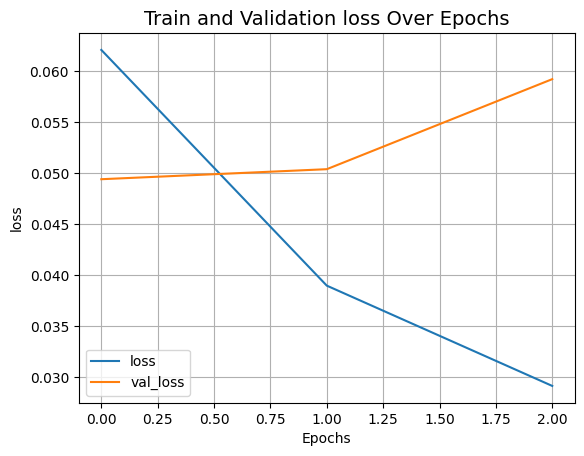

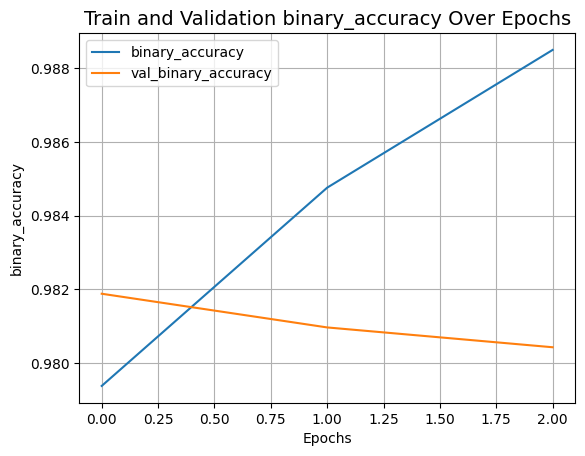

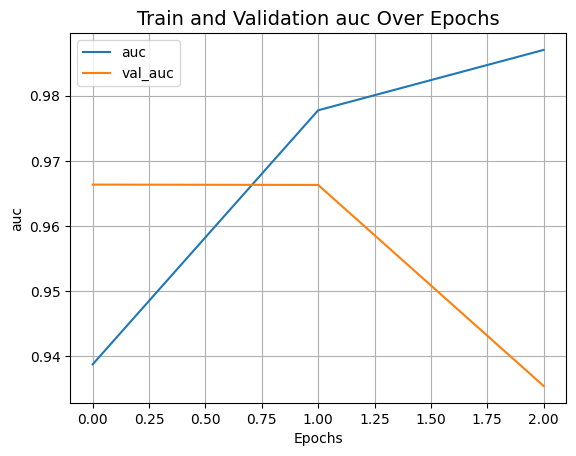

In [26]:
train_model(model_positional, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [27]:
model_positional.evaluate(ds_test)

1000/1000 [==============================] - 11s 11ms/step - loss: 0.0741 - binary_accuracy: 0.9703 - auc: 0.9649


[0.07406962662935257, 0.9703187942504883, 0.9648590087890625]

1000/1000 [==============================] - 10s 9ms/step
ROC AUC Score per Label	 [0.96086904 0.9854058  0.97596171 0.96215762 0.96635694 0.95771091]
Micro ROC AUC Score	 0.9763411033935174
Macro ROC AUC Score	 0.9680770065018542
Weighted ROC AUC Score	 0.9664934307960217
               precision    recall  f1-score   support

        toxic       0.57      0.81      0.67      6090
 severe_toxic       0.32      0.51      0.39       367
      obscene       0.68      0.72      0.70      3691
       threat       0.00      0.00      0.00       211
       insult       0.59      0.64      0.61      3427
identity_hate       0.58      0.01      0.02       712

    micro avg       0.59      0.69      0.64     14498
    macro avg       0.46      0.45      0.40     14498
 weighted avg       0.59      0.69      0.62     14498
  samples avg       0.07      0.06      0.06     14498

toxic - Acc: 0.9247 - Recall: 0.8067 - Precision: 0.5743 - F1 score: 0.6709


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


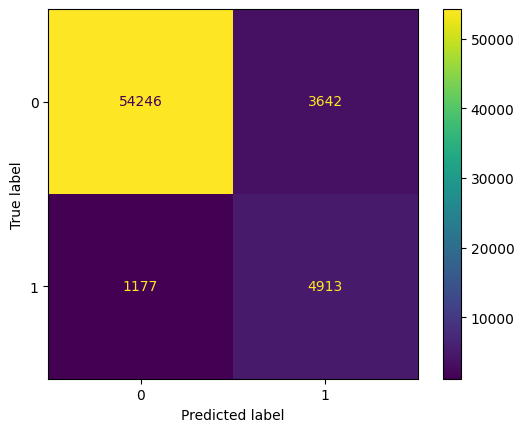

severe_toxic - Acc: 0.9910 - Recall: 0.5068 - Precision: 0.3201 - F1 score: 0.3924


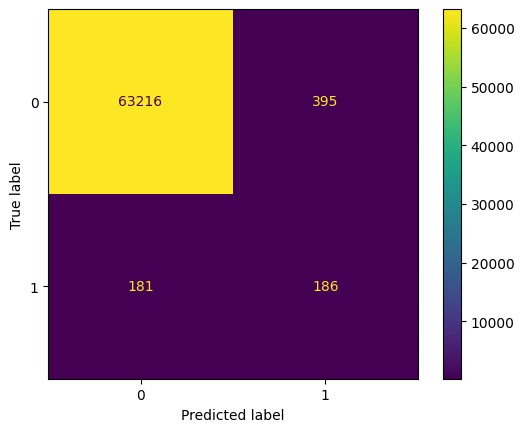

obscene - Acc: 0.9641 - Recall: 0.7239 - Precision: 0.6759 - F1 score: 0.6991


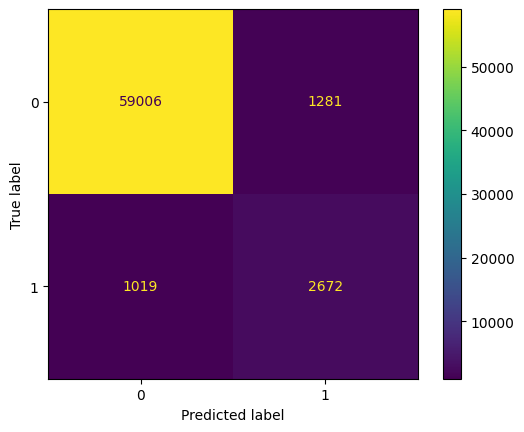

threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


<ipython-input-23-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


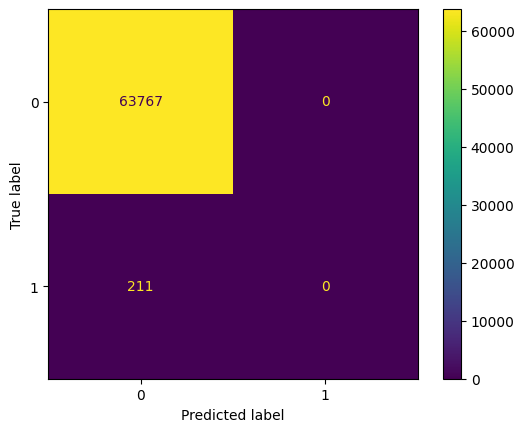

insult - Acc: 0.9566 - Recall: 0.6379 - Precision: 0.5872 - F1 score: 0.6115


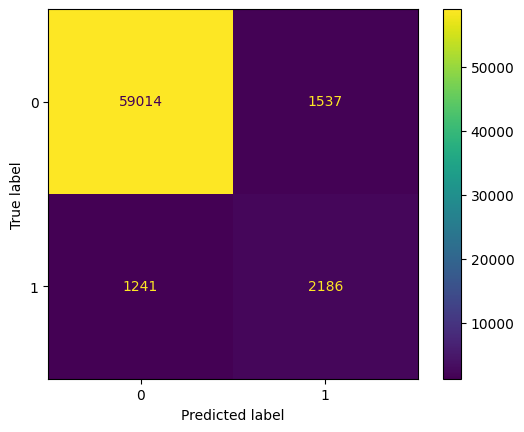

identity_hate - Acc: 0.9889 - Recall: 0.0098 - Precision: 0.5833 - F1 score: 0.0193


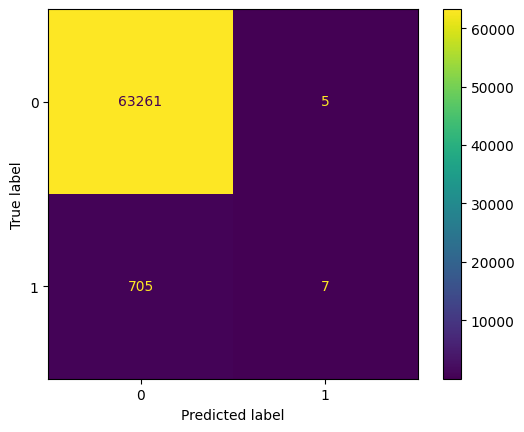

In [28]:
mp_preds = model_metrics(model_positional)

In [29]:
all_zero_predictions = model_comments(3, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwi

In [30]:
all_zero_predictions = model_comments(5, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g

### GLOVE (FROZEN WEIGHTS)

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

Epoch 1/20
1995/1995 [==============================] - 58s 27ms/step - loss: 0.0633 - binary_accuracy: 0.9784 - auc: 0.9494 - val_loss: 0.0512 - val_binary_accuracy: 0.9814 - val_auc: 0.9660
Epoch 2/20
1393/1995 [===================>..........] - ETA: 13s - loss: 0.0494 - binary_accuracy: 0.9819 - auc: 0.9678

In [ ]:
model_glove.evaluate(ds_test)

In [ ]:
mg_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mg_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

In [ ]:
all_zero_predictions = model_comments(5, mg_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

### GLOVE (TRAINABLE WEIGHTS)

In [ ]:
embedding_layer_glove.trainable = True
model_glove.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [ ]:
model_glove.evaluate(ds_test)

In [ ]:
mgt_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mgt_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

In [ ]:
all_zero_predictions = model_comments(5, mgt_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')